In [1]:
import math
import random
import PIL
import csv
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [2]:
def find_largest_contour(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour based on area
        largest_contour = max(contours, key=cv2.contourArea)
        return largest_contour
    return None


def crop_to_largest_cluster(image, mask):
    # Find the largest contour in the mask
    largest_contour = find_largest_contour(mask)
    if largest_contour is not None:
        # Compute the bounding rectangle for the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Crop the image using the bounding rectangle
        return image[y:y+h, x:x+w]
    return image  # Return original if no contours found

def get_cropped_image(image, mask, min_area=100, min_size=64, verbose=True):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        if verbose: print('no contours found.')
        return None 
    
    # remove any contours that are smaller than min_area
    valid_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]
    if verbose: print(f'after removing by size: {len(valid_contours)} valid contours')

    contour_size_check = len(valid_contours)

    # if there is only one contour left, it might just be very big on the screen, so give it more space
    if len(valid_contours) == 1:
        upper_limit = image.shape[0]*.10
        lower_limit = image.shape[0]*.90
    else:
        # check for contour centroid. if centroid is too far left,right of screen or too high up, remove it
        upper_limit = image.shape[0]*.25
        lower_limit = image.shape[0]*.75

    # check for contours that are too high up
    valid_contours_centroid = []
    for contour in valid_contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            # cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if upper_limit < cy < lower_limit:
                valid_contours_centroid.append(contour)

    valid_contours = valid_contours_centroid
    if verbose:  print(f'after removing by vertical centroid: {len(valid_contours)} valid contours')


    # remove again anything that is too small
    valid_contours = [contour for contour in valid_contours if cv2.contourArea(contour) >= min_area*2]
    if verbose:  print(f'after removing second size restriction: {len(valid_contours)} valid contours')

    # if len(valid_contours) == 1:
    #     left_limit = image.shape[1]*.05
    #     right_limit = image.shape[1]*.95
    # else:
    #     left_limit = image.shape[1]*.25
    #     right_limit = image.shape[1]*.75

    if len(valid_contours) > 1:
        if verbose:  print('after removing vertical centroids, too many contours are left')
        return None

    valid_contours_centroid = []

    left_limit = image.shape[1]*.05
    right_limit = image.shape[1]*.95
    
    for contour in valid_contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            if left_limit < cx < right_limit:
                valid_contours_centroid.append(contour)

    valid_contours = valid_contours_centroid
    if verbose: print(f'after removing by horizontal centroid: {len(valid_contours)} valid contours')

    # if there are too many contours left, it can mean there are too many signs on the screen
    # and therefore we can classify as just the wall
    if len(valid_contours) > 3:
        if verbose: print(f'too many contours found: {len(valid_contours)}')
        return None

    # if there are no valid contours, we are at a wall
    if not valid_contours:
        if verbose: print('no valid contours found.')
        return None

    # Get the largest contour based on area
    largest_contour = max(valid_contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(largest_contour)

    # if the contour we found is sort of tilted (we are seeing it from an angle) don't count it
    if w < 30 or w < h*.7:
        if verbose: print('contour width too small')
        return None
    
    # Ensure the cropped area is at least the provided min_size x min_size
    if w < min_size or h < min_size:
        # Calculate how much to add to width and height
        add_w = max(0, min_size - w) // 2
        add_h = max(0, min_size - h) // 2

        # Adjust x, y, w, h to maintain the minimum size and try to center the contour
        x = max(0, x - add_w)
        y = max(0, y - add_h)
        w = w + 2 * add_w
        h = h + 2 * add_h

        # Check boundaries so we don't go out of the image limits
        x = min(x, image.shape[1] - min_size)
        y = min(y, image.shape[0] - min_size)
        w = min(w, image.shape[1] - x)
        h = min(h, image.shape[0] - y)

    # Crop the image
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image


def filter_img(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # red mask
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)
    mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # blue mask
    lower_blue = np.array([110, 30, 30])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(img_hsv, lower_blue, upper_blue)

    # green mask
    lower_green = np.array([40, 25, 25])
    upper_green = np.array([80, 255, 255])
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green)

    mask = cv2.bitwise_or(red_mask, blue_mask)
    mask = cv2.bitwise_or(mask, green_mask)

    # mask[:int(mask.shape[0]*.2),:] = 0
    # mask[int(mask.shape[0]*.8):,:] = 0

    # get the largest contour only
    cropped_img = get_cropped_image(img, mask, verbose=False)

    if cropped_img is None:
        cropped_img = cv2.resize(img, (64,64))
    else:
        cropped_img = cv2.resize(cropped_img, (64,64))

    # cropped_img = crop_to_largest_cluster(img, mask)
    filtered_img = cv2.bitwise_and(img, img, mask=mask)

    return cropped_img


def check_extension(imageDir):
    for file in os.listdir(imageDir):
        if file[-3:] == 'jpg':
            return 'jpg'
        elif file[-3:] == 'png':
            return 'png'
        else:
            continue


def get_dataset(imageDir):
    data_list = []
    
    with open(imageDir + 'labels.txt', 'r') as f:
        reader = csv.reader(f)
        lines = list(reader)

    ext = check_extension(imageDir)
        
    for i, label in lines:
        # read in image
        img = np.array(cv2.imread(f'{imageDir}{i}.{ext}'))

        # print(f'label: {label}')

        filtered_img = filter_img(img)

        if filtered_img is None:
            # print('NONE')
            continue

        # concatenated_image = cv2.hconcat([img, filtered_img])
        # cv2.imshow('OG image', concatenated_image)
        # cv2.imshow('red',red_img)
        # cv2.imshow('blue',blue_img)
        # cv2.imshow('green',green_img)
        
        # cv2.imshow('og', img)
        # cv2.imshow('new', filtered_img)
        # cv2.waitKey(0)
            
        # img = cv2.resize(img, (25,33))
        data_list.append((filtered_img, int(label)))
            
    random.shuffle(data_list)

    train_ind = range(len(data_list))
    test_ind = random.sample(train_ind, int(len(train_ind)*0.2))
    train_ind = [item for item in train_ind if item not in test_ind]
    val_ind = random.sample(train_ind, int(len(train_ind)*0.2))
    train_ind = [item for item in train_ind if item not in val_ind]

    test_trials = np.array(data_list,dtype=object)[test_ind]
    val_trials = np.array(data_list,dtype=object)[val_ind]
    train_trials = np.array(data_list,dtype=object)[train_ind]
    
    return test_trials, val_trials, train_trials

In [3]:
imageDirs = ['2024Simgs/','2023Fimgs/','S2023_imgs/','2022Fimgs/','2022Fheldout/']
# imageDirs = ['S2023_imgs/']

test_data = None
train_data = None
val_data = None

for imdir in imageDirs:
    test_trials, val_trials, train_trials = get_dataset(imdir)
    
    if test_data is None:
        test_data = test_trials
        val_data = val_trials
        train_data = train_trials
    else:
        test_data = np.concatenate((test_data, test_trials))
        val_data = np.concatenate((val_data, val_trials))
        train_data = np.concatenate((train_data, train_trials))
    
print(f'test: {len(test_data)}')
print(f'validation: {len(val_data)}')
print(f'train: {len(train_data)}')

num_classes = len(np.unique(train_data[:,1]))
print(f'classes: {num_classes}')

print(train_data[0][0].shape)

test: 151
validation: 120
train: 492
classes: 6
(64, 64, 3)


In [4]:
def create_cnn(input_shape, num_classes, lr=0.00001):
#     model = Sequential([
#         layers.Rescaling(1./255, input_shape=input_shape), #this layer normalized the pixel values
# #         layers.Conv2D(16, 3, input_shape=input_shape, padding='same', 
# #                       activation='relu', kernel_regularizer=l2(0.01)),
# #         layers.MaxPooling2D((2,2)),
# #         layers.Dropout(0.3),
#         layers.Conv2D(32, 3, padding='same', activation='relu',
#                       kernel_regularizer=l2(0.01)),
#         layers.MaxPooling2D((2,2)),
#         layers.Dropout(0.4),
#         layers.Conv2D(64, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(num_classes) #output classification for the 6 classes
#     ])
    
    model = Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape,
                            kernel_regularizer=l2(0.01)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape,
                            kernel_regularizer=l2(0.01)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), padding='same', activation='relu', input_shape=input_shape,
                            kernel_regularizer=l2(0.01)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes)
    ])
    
    
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

In [5]:
input_shape = train_data[0][0].shape

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_cnn(input_shape,num_classes,lr=0.0001)

x_train = []
y_train = []
x_val = []
y_val = []

for data, label in train_data:
    x_train.append(data)
    y_train.append(label)

for data, label in val_data:
    x_val.append(data)
    y_val.append(label)    


x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)


history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), 
                    callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                    

16/16 [==============================] - 1s 42ms/step - loss: 0.9203 - accuracy: 0.8902 - val_loss: 0.8568 - val_accuracy: 0.9417
Epoch 42/500
16/16 [==============================] - 1s 42ms/step - loss: 0.9077 - accuracy: 0.9045 - val_loss: 0.8549 - val_accuracy: 0.9333
Epoch 43/500
16/16 [==============================] - 1s 42ms/step - loss: 0.8833 - accuracy: 0.9045 - val_loss: 0.8407 - val_accuracy: 0.9250
Epoch 44/500
16/16 [==============================] - 1s 42ms/step - loss: 0.9011 - accuracy: 0.8841 - val_loss: 0.8465 - val_accuracy: 0.9333
Epoch 45/500
16/16 [==============================] - 1s 42ms/step - loss: 0.8970 - accuracy: 0.8963 - val_loss: 0.8324 - val_accuracy: 0.9417
Epoch 46/500
16/16 [==============================] - 1s 44ms/step - loss: 0.8759 - accuracy: 0.8923 - val_loss: 0.8096 - val_accuracy: 0.9167
Epoch 47/500
16/16 [==============================] - 1s 42ms/step - loss: 0.8633 - accuracy: 0.8984 - val_loss: 0.8118 - val_accuracy: 0.9333
Epoch 48/500

16/16 [==============================] - 1s 44ms/step - loss: 0.5183 - accuracy: 0.9248 - val_loss: 0.5802 - val_accuracy: 0.9417
Epoch 99/500
16/16 [==============================] - 1s 41ms/step - loss: 0.5153 - accuracy: 0.9309 - val_loss: 0.5918 - val_accuracy: 0.9500
Epoch 100/500
16/16 [==============================] - 1s 42ms/step - loss: 0.5093 - accuracy: 0.9268 - val_loss: 0.5908 - val_accuracy: 0.9417
Epoch 101/500
16/16 [==============================] - 1s 41ms/step - loss: 0.5113 - accuracy: 0.9248 - val_loss: 0.5798 - val_accuracy: 0.9417
Epoch 102/500
16/16 [==============================] - 1s 42ms/step - loss: 0.5127 - accuracy: 0.9268 - val_loss: 0.5789 - val_accuracy: 0.9417
Epoch 103/500
16/16 [==============================] - 1s 43ms/step - loss: 0.5043 - accuracy: 0.9187 - val_loss: 0.5905 - val_accuracy: 0.9333
Epoch 104/500
16/16 [==============================] - 1s 45ms/step - loss: 0.5076 - accuracy: 0.9329 - val_loss: 0.5811 - val_accuracy: 0.9417
Epoch 1

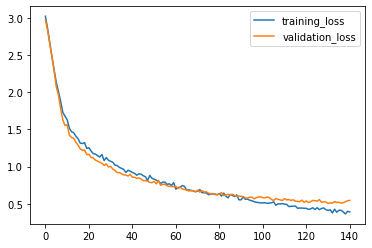

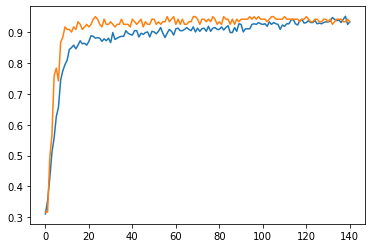

In [6]:
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'],label='training_acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [7]:
x_test = []
y_test = []

for data, label in test_data:
    x_test.append(data)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)


pred = model.predict(x_test)
pred = np.argmax(pred, axis=-1)    

test_acc = len(np.where(pred == y_test)[0])/len(y_test)
print(test_acc)

5/5 [==============================] - 0s 12ms/step
0.9205298013245033


In [12]:
from sklearn.metrics import confusion_matrix

result = confusion_matrix(y_test, pred)
print(f'Total accuracy: {test_acc}')
print(result)

Total accuracy: 0.9205298013245033
[[11  0  1  0  0  0]
 [ 2 44  1  0  0  0]
 [ 1  0 39  0  0  1]
 [ 0  0  0 13  0  0]
 [ 3  0  0  0 18  0]
 [ 3  0  0  0  0 14]]


# KNN

In [ ]:
from skimage.feature import hog

def get_dataset(imageDirectory, new_shape):
    data_list = []
    
    with open(imageDirectory + 'labels.txt', 'r') as f:
        reader = csv.reader(f)
        lines = list(reader)

    random.shuffle(lines)

    # this line reads in all images listed in the file in color, and resizes them to 25x33 pixels
    for i in range(len(lines)):
        img = cv2.imread(imageDirectory+lines[i][0]+".jpg")
        try:
            img.shape
        except:
            img = cv2.imread(imageDirectory+lines[i][0]+".png")
#             cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
#         img = cv2.GaussianBlur(img,(3,3),0)
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, new_shape)
#         img = cv2.Canny(img,150,200)
        
#         cv2.imshow('edge', img)
#         cv2.waitKey(0)
    
#         fd, img = hog(
#             img,
#             orientations=8,
#             pixels_per_cell=(16, 16),
#             cells_per_block=(1, 1),
#             visualize=True,
#         )

        
        
        data_list.append(img)
       
    train_list = np.array(data_list)
    train_labels = np.array([np.int32(lines[i][1]) for i in range(len(lines))])
    train_data = train_list.flatten().reshape(len(train_list), img.shape[0]*img.shape[1]*3)

    return np.asarray(train_data).astype(np.float32), train_labels  

In [ ]:
# imageDirs = ['2023Fimgs/','S2023_imgs/','2022Fimgs/','2022Fheldout/']
imageDirs = ['2023Fimgs/']
new_shape = (32,32)

# for imdir in imageDirs:
#     train_data, train_labels = get_dataset(imdir)
    
# #     if test_data is None:
# #         test_data = test_trials
# #         val_data = val_trials
# #         train_data = train_trials
# #     else:
# #         test_data = np.concatenate((test_data, test_trials))
# #         val_data = np.concatenate((val_data, val_trials))
# #         train_data = np.concatenate((train_data, train_trials))
    
    
train_data, train_labels = get_dataset('2023Fimgs/', new_shape)
print(train_data.shape, train_labels.shape)

knn = cv2.ml.KNearest_create()
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

In [ ]:
test_data, test_labels = get_dataset('S2023_imgs/', new_shape)

k = 5
correct = 0

for i in range(test_data.shape[0]):
    test_img = test_data[i,:].reshape(1,len(test_data[i,:])).astype(np.float32)
    test_label = np.int32(test_labels[i])
    
    ret, results, neighbours, dist = knn.findNearest(test_img, k)
    
    if test_label == ret:
        correct += 1
        
accuracy = correct / test_data.shape[0]
print(accuracy)

In [ ]:
from cv2 import ml, TERM_CRITERIA_MAX_ITER, TERM_CRITERIA_EPS

# Create a new SVM
svm_digits = ml.SVM_create()

# Set the SVM kernel to RBF
svm_digits.setKernel(ml.SVM_RBF)
svm_digits.setType(ml.SVM_C_SVC)
svm_digits.setGamma(0.5)
svm_digits.setC(12)
svm_digits.setTermCriteria((TERM_CRITERIA_MAX_ITER + TERM_CRITERIA_EPS, 100, 1e-6))

# # Converting the image data into HOG descriptors
# digits_train_hog = hog_descriptors(digits_train_imgs)
# digits_test_hog = hog_descriptors(digits_test_imgs)

# Train the SVM on the set of training data
svm_digits.train(train_data, ml.ROW_SAMPLE, train_labels)


In [ ]:
test_data, test_labels = get_dataset('S2023_imgs/', new_shape)

correct = 0

for i in range(test_data.shape[0]):
    test_img = test_data[i,:].reshape(1,len(test_data[i,:])).astype(np.float32)
    test_label = np.int32(test_labels[i])
    
    _, ret = svm_digits.predict(test_img)
    
    if test_label == ret:
        correct += 1
        
accuracy = correct / test_data.shape[0]
print(accuracy)

In [ ]:
def check_extension(imageDir):
    for file in os.listdir(imageDir):
        if file[-4:] == 'jpg':
            return 'jpg'
        else:
            return 'png'
        
print(check_extension('2023Fimgs'))
